In [15]:
##libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Input

In [2]:
##project constant
RAW_DIR="data/Art"
IMG_HEIGHT=180
IMG_WIDTH=180
EPOCH=10
BATCH_SIZE=16
SEED=42
CHANNELS=3

In [3]:
##loading dataset
raw_data=tf.keras.preprocessing.image_dataset_from_directory(
   RAW_DIR,
   image_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   shuffle=True 
)

Found 971 files belonging to 2 classes.


In [4]:
##checking class names
art_class=raw_data.class_names

In [5]:
##number of class
n_class=len(raw_data.class_names)
n_class

2

2026-01-18 20:10:00.797427: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


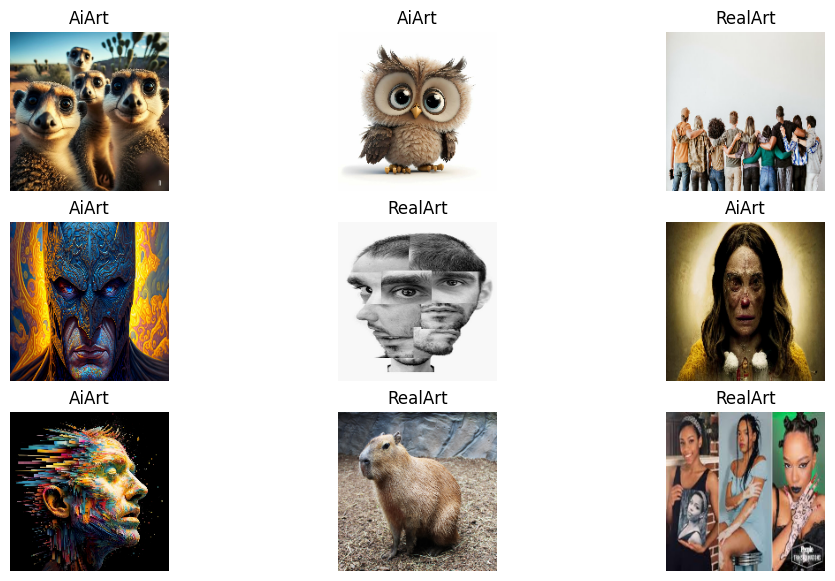

In [6]:
##show image
plt.figure(figsize=(12,7))
for image, label in raw_data.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(art_class[label[i]])
        plt.axis('off')
plt.show()

In [10]:
##data splitter function
def data_splitter(image_data, 
                  train_split_size=0.8, 
                  val_split_size=0.1,  
                  shuffle=True,
                  shuffle_size=1000):
    if shuffle:
        image_data=image_data.shuffle(shuffle_size, SEED)
    ##total image
    total_img=len(image_data)

    ##total train split images
    train_image_size=int(total_img*train_split_size)
    val_image_size=int(total_img*val_split_size)

    ##images on each split on the raw dataset
    train_ds=image_data.take(train_image_size)
    val_ds=image_data.skip(train_image_size).take(val_image_size)
    test_ds=image_data.skip(train_image_size).skip(val_image_size)

    return train_ds, val_ds, test_ds


In [11]:
##split the data
train, val, test= data_splitter(raw_data)

In [12]:
len(train), len(val), len(test)

(48, 6, 7)

In [17]:
##model 
model=Sequential([
    ##input size of the image
    layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH, CHANNELS)),
    ##normalization of the image
    layers.Rescaling(1./255.),
    ##convolution layers
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    ##batch normalization
    layers.BatchNormalization(),
    ##pooling layers
    layers.MaxPool2D(),

    ##2nd convolutional layers
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu'),
    ##maxpooling
    layers.MaxPool2D(),

    ##3rd convolutional layers
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPool2D(),
    ##to reduce overfitting add dropout layers
    layers.Dropout(0.5),

    ##flatten layer to convert the matrix into vector
    layers.Flatten(),
    ##dense hidden layers
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_class, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 180, 180, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 88, 88, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 44, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       903,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,008,162 (3.85 MB)

 Trainable params: 1,007,906 (3.84 MB)

 Non-trainable params: 256 (1.00 KB)